In [77]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from category_encoders import TargetEncoder


In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import warnings
from numba import NumbaDeprecationWarning

warnings.filterwarnings(
    "ignore",
    message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
    category=FutureWarning,
)
warnings.filterwarnings(
    "ignore",
    message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
    category=FutureWarning,
)
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)

In [80]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

In [81]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [82]:
config_path = op.join('newconf', 'config.yml')
context = create_context(config_path)

In [83]:
train_X = load_dataset(context, 'train/housing/features')
train_y = load_dataset(context, 'train/housing/target')
print(train_X.shape, train_y.shape)

test_X = load_dataset(context, 'test/housing/features')
test_y = load_dataset(context, 'test/housing/target')
print(test_X.shape, test_y.shape)

(16512, 9) (16512, 1)
(4128, 9) (4128, 1)


In [84]:
# collecting different types of columns for transformations
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns

In [85]:
outlier_transformer = Outlier(method='mean')
print(train_X.shape)
train_X = outlier_transformer.fit_transform(train_X)
print(train_X.shape)

(16512, 9)
(16512, 9)


In [86]:


# NOTE: the list of transformations here are not sequential but weighted 
# (if multiple transforms are specified for a particular column)
# for sequential transforms use a pipeline as shown above.
features_transformer = ColumnTransformer([
    
    ## categorical columns
    ('tgt_enc', TargetEncoder(return_df=False),
     list(set(cat_columns))),
    ## numeric columns
    ('med_enc', SimpleImputer(strategy='median'), num_columns),
])


In [87]:
sample_X = train_X.sample(frac=0.1, random_state=context.random_seed)
sample_y = train_y.loc[sample_X.index]

sample_train_X = get_dataframe(
    features_transformer.fit_transform(sample_X, sample_y), 
    get_feature_names_from_column_transformer(features_transformer)
)

# nothing to do for target
sample_train_y = sample_y

In [88]:
train_X = get_dataframe(
    features_transformer.fit_transform(train_X, train_y), 
    get_feature_names_from_column_transformer(features_transformer)
)

In [89]:
train_X

,ocean_proximity,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,240065.448564,-118.04,33.99,47.0,2530.0,565.0,1262.0,509.0,3.6475
1,258873.332604,-122.20,37.82,37.0,1229.0,181.0,420.0,176.0,7.0175
2,240065.448564,-118.25,34.09,52.0,3142.0,765.0,1728.0,682.0,3.1864
3,240065.448564,-117.99,33.70,25.0,2017.0,357.0,1063.0,369.0,4.0345
4,124912.128694,-120.88,37.52,2.0,1871.0,409.0,707.0,256.0,2.6103
...,...,...,...,...,...,...,...,...,...
16507,240065.448564,-118.16,34.09,33.0,1515.0,415.0,1345.0,346.0,2.3750
16508,124912.128694,-116.46,33.78,33.0,2565.0,745.0,2301.0,638.0,2.5477
16509,258873.332604,-122.07,37.58,16.0,1606.0,240.0,1117.0,268.0,6.0661
16510,258873.332604,-122.43,37.78,52.0,1952.0,628.0,1284.0,576.0,2.1050


In [90]:
out = eda.get_density_plots(train_X, cols=['ocean_proximity', 'housing_median_age'])
out

:DynamicMap   [col]
   :Layout
      .Overlay.I :Overlay
         .Histogram.I    :Histogram   [x]   (Frequency)
         .Distribution.I :Distribution   [ocean_proximity]   (Density)
      .Table.I   :Table   [count,mean,std,min,25%,50%,75%,max]

In [91]:
# save the plots are html
reports.create_report({'univariate': out}, name='reports_new/feature_analysis_univariate')

In [92]:
reports.feature_analysis(train_X,'reports_new/feature_analysis_report.html')

p-value may not be accurate for N > 5000.


In [93]:
out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,households,total_bedrooms,0.972044,0.972044
1,latitude,longitude,-0.925628,0.925628
2,total_bedrooms,total_rooms,0.920203,0.920203
3,households,total_rooms,0.912943,0.912943
4,households,population,0.908202,0.908202
5,population,total_bedrooms,0.872036,0.872036
6,population,total_rooms,0.841843,0.841843


In [94]:
out = eda.get_bivariate_plots(train_X, x_cols=['population'], y_cols=['households'])
out

:HexTiles   [population,households]

In [95]:
%%time
# create reports as needed
cols = train_X.columns.to_list()
all_plots = {}
for ii, col1 in enumerate(cols): 
    for jj in range(ii+1, len(cols)):
        col2 = cols[jj]
        out = eda.get_bivariate_plots(train_X, x_cols=[col1], y_cols=[col2])
        all_plots.update({f'{col2} vs {col1}': out})

reports.create_report(all_plots, name='reports_new/feature_analysis_bivariate')

CPU times: user 2.98 s, sys: 29.2 ms, total: 3.01 s
Wall time: 3.01 s


In [96]:
reports.feature_interactions(train_X,'reports_new/feature_interaction_report.html')

In [97]:
out = eda.get_target_correlation(train_X, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')

In [98]:
train_y["median_house_value"]

0        197100.0
1        366700.0
2        189800.0
3        229400.0
4        133600.0
           ...   
16507    175000.0
16508     83000.0
16509    247000.0
16510    316700.0
16511    253800.0
Name: median_house_value, Length: 16512, dtype: float64

Tabs
    [0] HoloViews(Bars, name='from_model')
    [1] Matplotlib(Figure, name='shap_values')
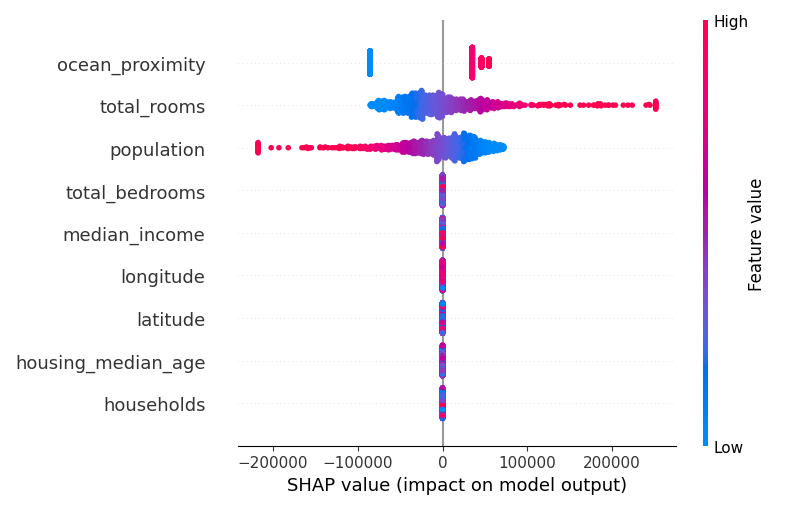

In [99]:
out = eda.get_feature_importances(train_X, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

In [100]:
reports.key_drivers(train_X,train_y, 'reports_new/key_drivers_report.html', y_continuous=True)

In [101]:
reports.data_exploration(train_X,train_y,'reports_new/data_exploration_report.html', y_continuous=True)

p-value may not be accurate for N > 5000.


In [102]:
curated_columns = train_X.columns.to_list()

# saving the list of relevant columns
save_pipeline(curated_columns, op.abspath(op.join(artifacts_folder, 'curated_columns.joblib')))

# save the feature pipeline
save_pipeline(features_transformer, op.abspath(op.join(artifacts_folder, 'features.joblib')))

In [103]:
cols = list(train_X.columns)
vif = eda.calc_vif(train_X)
while max(vif.VIF) > 15:
    #removing the largest variable from VIF
    cols.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = eda.calc_vif(train_X[cols])

In [104]:
reg_vars = vif.query('VIF < 15').variables
reg_vars = list(reg_vars)

In [105]:
# Custom Transformations like these can be utilised
def _custom_data_transform(df, cols2keep=None):
    """Transformation to drop some columns in the data
    
    Parameters
    ----------
        df - pd.DataFrame
        cols2keep - columns to keep in the dataframe
    """
    cols2keep = cols2keep or []
    if len(cols2keep):
        return (df
                .select_columns(cols2keep))
    else:
        return df

In [106]:
reg_ppln_ols = Pipeline([
    ('',FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(train_X, train_y.values.ravel())


Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f4211a42160>,
                                     kw_args={'cols2keep': ['ocean_proximity',
                                                            'housing_median_age',
                                                            'total_bedrooms',
                                                            'population',
                                                            'median_income']})),
                ('estimator', SKLStatsmodelOLS())])

In [107]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     6064.
Date:                Fri, 06 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:15:44   Log-Likelihood:            -2.0729e+05
No. Observations:               16512   AIC:                         4.146e+05
Df Residuals:                   16506   BIC:                         4.146e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept          -1.293e+05   2631.789    -49.117      0.000   -1.34e+05   -1.24e+05
ocean_proximity        0.6111      0.010     59.159      0.000       0.591       0.631
housing_median_age  1275.1134     48.101     26.509      0.000    1180.831    1369.396
total_bedrooms       139.2142      3.165     43.991      0.000     133.011     145.417
population           -45.3587      1.185    -38.291      0.000     -47.681     -43.037
median_income       4.256e+04    320.351    132.858      0.000    4.19e+04    4.32e+04
==============================================================================
Omnibus:                     3551.812   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10060.747
Skew:                           1.135   Prob(JB):                         0.00
Kurtosis:                       6.077   Cond. No.                     1.06e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [108]:
reg_ppln = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('Linear Regression', SKLStatsmodelOLS())
])
test_X = get_dataframe(
    features_transformer.transform(test_X), 
    get_feature_names_from_column_transformer(features_transformer)
)

In [109]:
reg_linear_report = RegressionReport(model=reg_ppln, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y, refit=True)
reg_linear_report.get_report(include_shap=False, file_path='reports_new/regression_linear_model_report')

In [110]:
threshold=0.3
residual_analysis = test_X.copy()
residual_analysis['prediction'] = reg_ppln_ols.predict(test_X)
residual_analysis['actuals'] = test_y.reset_index(drop = True).iloc[:,0].values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[((residual_analysis['prediction'] > (1+threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'over predict'
residual_analysis.loc[((residual_analysis['prediction'] < (1-threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'under predict'

In [111]:
residual_analysis.hvplot.kde(y="prediction",by="forecast_flag", ## Grouping by Predictions
                                width=800, height=400,
                                alpha=0.7,
                                ylabel="density",
                                xlabel="medianouse_value",
                                title=f'median_house_value(density)',legend='top_right')

# residual_analysis

:NdOverlay   [forecast_flag]
   :Distribution   [prediction]   (Density)

In [112]:
# let's find features for some decent defaults
estimator = XGBRegressor()
xgb_training_pipe_init = Pipeline([
    ('XGBoost', XGBRegressor())
])
xgb_training_pipe_init.fit(train_X, train_y)

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=14, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

<AxesSubplot:>

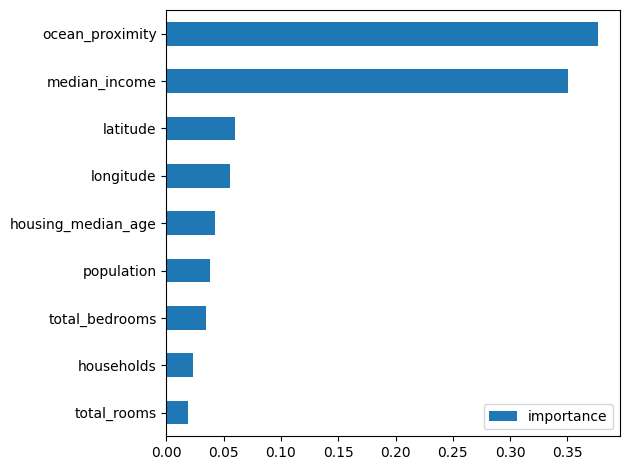

In [113]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame({'importance': xgb_training_pipe_init['XGBoost'].feature_importances_})
imp.index = train_X.columns
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

In [114]:
# let's find features for some decent defaults
imp_features = ['model_family','sku','unit_cost','condition','brand','business_unit']

estimator = XGBRegressor()
xgb_training_pipe2 = Pipeline([
    ('', FunctionTransformer(_custom_data_transform)),
    ('XGBoost', XGBRegressor())
])

In [115]:
%%time
parameters = {
   'gamma':[0.03],
   'min_child_weight':[6],
   'learning_rate':[0.1],
   'max_depth':[3],
   'n_estimators':[500], 
}
est = XGBRegressor()
xgb_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(train_X, train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/paduruvignatejreddy/conda/envs/reg-dev/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/paduruvignatejreddy/conda/envs/reg-dev/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/paduruvignatejreddy/conda/envs/reg-dev/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/paduruvignatejreddy/conda/envs/reg-dev/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarn

0.8159142949475958
{'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 500}
CPU times: user 8min 37s, sys: 881 ms, total: 8min 38s
Wall time: 5min 28s


In [116]:
xgb_pipeline_final = Pipeline([
    ('', FunctionTransformer(_custom_data_transform)),
    ('XGBoost', xgb_grid.best_estimator_)
])
xgb_pipeline_final.fit(train_X, train_y)

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f4211a42160>)),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0.03, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=6,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=14, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [117]:
reg_tree_report = RegressionReport(model=xgb_pipeline_final, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y)
reg_tree_report.get_report(include_shap=False, file_path='reports_new/regression_tree_model_report')

In [118]:
train_X.shape, train_y.shape

((16512, 9), (16512, 1))